In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
#load data
X_train = np.load('/content/drive/MyDrive/3730-proj/X_train.npy')
y_train = np.load('/content/drive/MyDrive/3730-proj/y_train.npy')
X_test = np.load('/content/drive/MyDrive/3730-proj/X_test.npy')
y_test = np.load('/content/drive/MyDrive/3730-proj/y_test.npy')

In [22]:
# Preprocess images: Crop the central 224x224 from each 256x256 image
def crop_center(img):
    center = img.shape[0] // 2
    return img[center-112:center+112, center-112:center+112, :]

X_train = np.array([crop_center(img) for img in X_train])
X_test = np.array([crop_center(img) for img in X_test])

In [23]:
X_train.shape

(28086, 224, 224, 3)

In [3]:
# Function to convert images to grayscale
def rgb_to_grayscale(images):
    return np.dot(images[...,:3], [0.21, 0.72, 0.07])


X_train_gray = rgb_to_grayscale(X_train)
X_test_gray = rgb_to_grayscale(X_test)

#normalize data
# X_train = X_train/255
# X_test = X_test/255
 #one hot


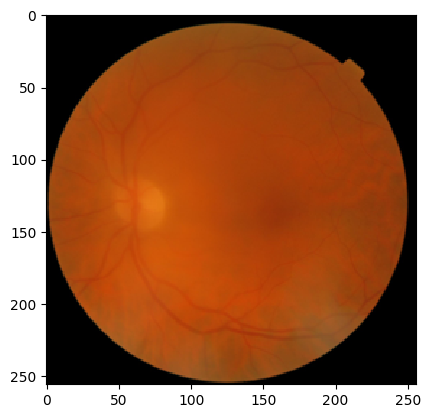

In [18]:
from matplotlib import pyplot as plt
plt.imshow(X_train[100], interpolation='nearest')
plt.show()

In [4]:
def sparse_focal_categorical_crossentropy(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.float32)

    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

    y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])

    cross_entropy = -y_true * tf.math.log(y_pred)

    loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy

    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(16, (3,3), padding='same', input_shape=(256,256,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2))) #128x128

# Convolutional Layer 2
model.add(Conv2D(32, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2))) #64x64

# Flattening and Fully Connected Layers
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# Compiling the model

model.compile(optimizer='adam', loss=sparse_focal_categorical_crossentropy, metrics=['accuracy'])

In [43]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load the pretrained EfficientNet model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)  # Assuming 5 classes

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [44]:
from tensorflow.keras import layers

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight


MODEL_NAME = 'efficient_net_unfroze'

model.summary()

#save summary of model
with open('/content/drive/MyDrive/3730-proj/' + MODEL_NAME + '_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

early_stop = EarlyStopping(monitor='val_loss', patience=20)

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))




model_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/3730-proj/' +MODEL_NAME + '_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


history = model.fit(X_train, y_train, epochs=300,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop, model_checkpoint], batch_size=128)



Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_14 (Rescaling)    (None, 224, 224, 3)          0         ['input_8[0][0]']             
                                                                                                  
 normalization_7 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_14[0][0]']        
 tion)                                                                                            
                                                                                                  
 rescaling_15 (Rescaling)    (None, 224, 224, 3)          0         ['normalization_7[0][0]'

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


220/220 [==============================] - 26s 82ms/step - loss: 0.7918 - accuracy: 0.7371 - val_loss: 0.6929 - val_accuracy: 0.7680
Epoch 2/300
219/220 [============================>.] - ETA: 0s - loss: 0.7034 - accuracy: 0.7604
Epoch 2: val_loss improved from 0.69286 to 0.67118, saving model to /content/drive/MyDrive/3730-proj/efficient_net_unfroze_best_model.h5
220/220 [==============================] - 16s 72ms/step - loss: 0.7038 - accuracy: 0.7603 - val_loss: 0.6712 - val_accuracy: 0.7764
Epoch 3/300
219/220 [============================>.] - ETA: 0s - loss: 0.6761 - accuracy: 0.7668
Epoch 3: val_loss improved from 0.67118 to 0.66167, saving model to /content/drive/MyDrive/3730-proj/efficient_net_unfroze_best_model.h5
220/220 [==============================] - 16s 72ms/step - loss: 0.6758 - accuracy: 0.7670 - val_loss: 0.6617 - val_accuracy: 0.7776
Epoch 4/300
219/220 [============================>.] - ETA: 0s - loss: 0.6506 - accuracy: 0.7757
Epoch 4: val_loss improved from 0.66

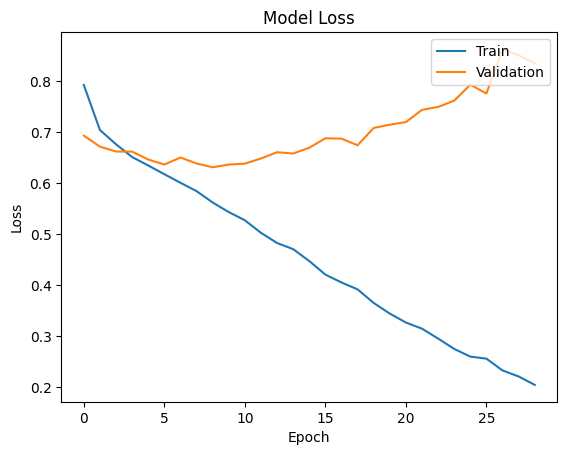

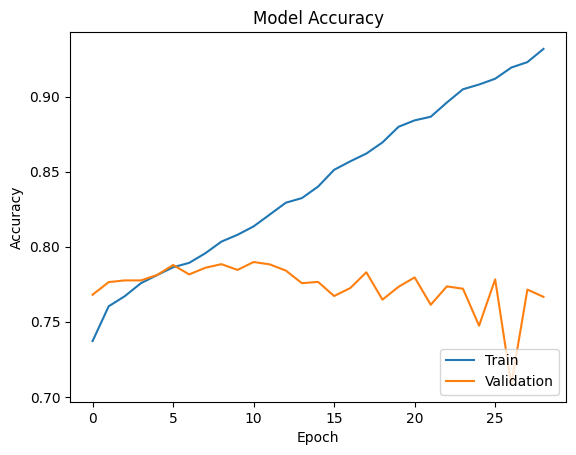

220/220 [==============================] - 5s 16ms/step


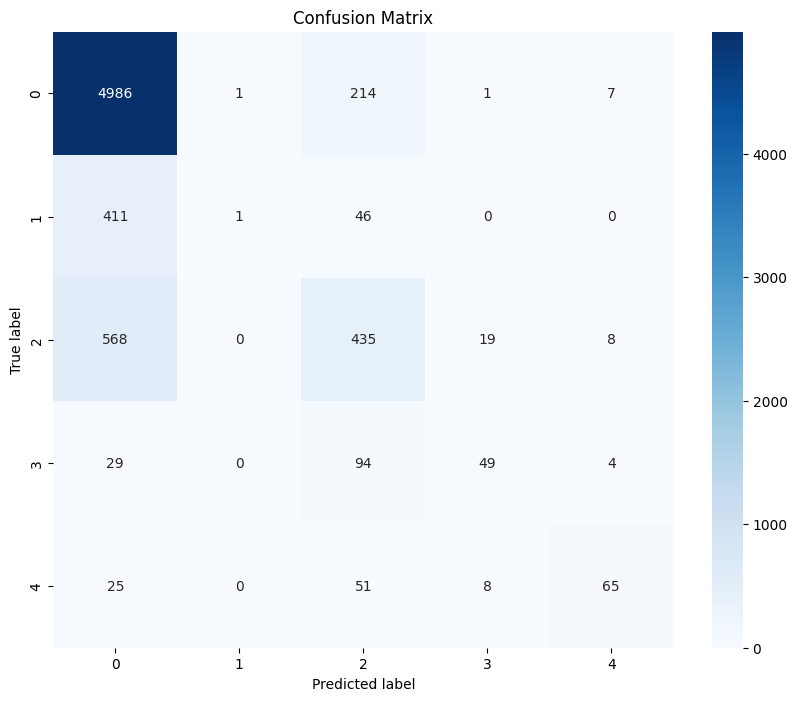

In [46]:
# Save Model and graphs
best_model = load_model('/content/drive/MyDrive/3730-proj/' +MODEL_NAME + '_best_model.h5',
                        custom_objects={'sparse_focal_categorical_crossentropy': sparse_focal_categorical_crossentropy})



### LOSS PLOT
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('/content/drive/MyDrive/3730-proj/' + MODEL_NAME + '_loss.png')
plt.show()
plt.clf()


### ACCURACY PLOT
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('/content/drive/MyDrive/3730-proj/' + MODEL_NAME + '_accuracy.png')
plt.show()

### CONFUSION MATRIX

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = y_test

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('/content/drive/MyDrive/3730-proj/' + MODEL_NAME + '_confusion_matrix.png')
plt.show()